# sessional assignment

In [29]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
# Step 2: Load the dataset
dataset_dir = r'C:\Users\HP\Desktop\FaceRec\merged\images'

In [3]:
num_images_to_load = 3000  # Adjust as needed

def load_dataset(dataset_dir, num_images):
    images = []
    image_files = os.listdir(dataset_dir)[:num_images]
    for image_file in image_files:
        image_path = os.path.join(dataset_dir, image_file)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        images.append(image)
    return images
images = load_dataset(dataset_dir, num_images_to_load)

In [4]:
import cv2
import numpy as np
from tqdm import tqdm

def annotate_faces(images):
    annotations = []
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    for image in tqdm(images):
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)
        annotation = []
        for (x,y,w,h) in faces:
            annotation.append([1, (x + w / 2) / image.shape[1], (y + h / 2) / image.shape[0], w / image.shape[1], h / image.shape[0]])
        annotations.append(annotation)

    return annotations

annotations = annotate_faces(images)


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [14:11<00:00,  3.52it/s]


In [ ]:
import cv2
import os
import time
import numpy as np

def load_yolov3_model(weights_path, config_path):
    net = cv2.dnn.readNetFromDarknet(config_path, weights_path)
    return net

def detect_objects_with_yolov3(yolo_model, images):
    detected_objects = []

    for image in images:
        blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)
        yolo_model.setInput(blob)
        outputs = yolo_model.forward(yolo_model.getUnconnectedOutLayersNames())

        boxes = []
        confidences = []
        class_ids = []

        for output in outputs:
            for detection in output:
                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]

                if confidence > 0.5:
                    center_x = int(detection[0] * image.shape[1])
                    center_y = int(detection[1] * image.shape[0])
                    width = int(detection[2] * image.shape[1])
                    height = int(detection[3] * image.shape[0])

                    x = int(center_x - width / 2)
                    y = int(center_y - height / 2)

                    boxes.append([x, y, width, height])
                    print(f'Confidence Score : {confidence}')
                    confidences.append(float(confidence))
                    class_ids.append(class_id)

        indices = cv2.dnn.NMSBoxes(boxes, confidences, score_threshold=0.5, nms_threshold=0.4)

        detected_objects_in_image = []
        if len(indices) > 0:
            for i in indices.flatten():
                x, y, w, h = boxes[i]
                detected_objects_in_image.append((x, y, w, h, class_ids[i]))

        detected_objects.append(detected_objects_in_image)

    return detected_objects

# Load YOLOv3 model
yolo_weights_path = r'C:\Users\HP\Desktop\FaceRec\config-files\facefinal.weights' #r'C:\Users\HP\Desktop\FaceRec\merged\yolov3.weights'
yolo_config_path =  r'C:\Users\HP\Desktop\FaceRec\config-files\facefinal.cfg' #r'C:\Users\HP\Desktop\FaceRec\merged\yolov3.cfg'
yolo_model = load_yolov3_model(yolo_weights_path, yolo_config_path)

# Load images from directory
current_path = r'C:\Users\HP\Desktop\FaceRec\merged'
image_dir = "images"
image_path = os.path.join(current_path, image_dir)
image_names = os.listdir(image_path)

# Create results directory if it does not exist
saving_directory = os.path.join(current_path, "results")
if not os.path.exists(saving_directory):
    os.makedirs(saving_directory)

# Process images in batches
batch_size = 5
num_batches = -(-len(image_names) // batch_size)  # Round up division

start_time = time.time()

for i in range(num_batches):
    start_index = i * batch_size
    end_index = min(start_index + batch_size, len(image_names))
    batch_image_names = image_names[start_index:end_index]
    batch_images = [cv2.imread(os.path.join(image_path, image_name)) for image_name in batch_image_names]

    # Detect objects in the images using YOLOv3
    detected_objects = detect_objects_with_yolov3(yolo_model, batch_images)

    for j, (image, objects_in_image) in enumerate(zip(batch_images, detected_objects)):
        for obj in objects_in_image:
            x, y, w, h, class_id = obj

            # Check if the detected object is a face
            if class_id == 0:  # Assuming class ID 0 represents faces
                # Draw rectangle on the image
                cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
                print("Drawing Rectangle"
        # Save annotated image
        saving_name = os.path.join(saving_directory, batch_image_names[j])
        cv2.imwrite(saving_name, image)
# Calculate and print FPS and elapsed time
finish_time = time.time()
elapsed_time = finish_time - start_time
fps = len(image_names) / elapsed_time
print("FPS = " + str(fps) + "\n" + "Elapsed Time = " + str(elapsed_time))


Confidence Score : 0.821476399898529
Confidence Score : 0.7514584064483643
Confidence Score : 0.6286357641220093
Confidence Score : 0.9896713495254517
Confidence Score : 0.6890044808387756
Confidence Score : 0.9994101524353027
Confidence Score : 0.5638195872306824
Confidence Score : 0.9961339235305786
Confidence Score : 0.8152433633804321
Confidence Score : 0.9551945328712463
Confidence Score : 0.9666922092437744
Confidence Score : 0.9738591313362122
Confidence Score : 0.9835721850395203
Confidence Score : 0.523757815361023
Confidence Score : 0.5836250185966492
Confidence Score : 0.9977741837501526
Confidence Score : 0.9977450370788574
Confidence Score : 0.6822410225868225
Confidence Score : 0.9920319318771362
Confidence Score : 0.6986036896705627
Confidence Score : 0.9647533297538757
Confidence Score : 0.5568806529045105
Confidence Score : 0.6397395730018616
Confidence Score : 0.8365969657897949
Confidence Score : 0.7539070844650269
Confidence Score : 0.8345373868942261
Confidence Sco

In [6]:
import cv2
import os
import numpy as np

# Paths
current_path = r'C:\Users\HP\Desktop\FaceRec\merged'
image_dir = "images"
result_dir = "results"
image_path = os.path.join(current_path, image_dir)
result_path = os.path.join(current_path, result_dir)

# Randomly select an image from both folders
image_names = os.listdir(image_path)
result_names = os.listdir(result_path)

random_image_name = np.random.choice(image_names)
random_result_name = np.random.choice(result_names)

# Load and display or print the randomly selected images
random_image = cv2.imread(os.path.join(image_path, random_image_name))
random_result = cv2.imread(os.path.join(result_path, random_result_name))

# Display images
cv2.imshow("Random Image from 'images' Folder", random_image)
cv2.imshow("Random Image from 'results' Folder", random_result)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Alternatively, print image paths
print("Random Image from 'images' Folder:", os.path.join(image_path, random_image_name))
print("Random Image from 'results' Folder:", os.path.join(result_path, random_result_name))


Random Image from 'images' Folder: C:\Users\HP\Desktop\FaceRec\merged\images\c2d598297aeadeef.jpg
Random Image from 'results' Folder: C:\Users\HP\Desktop\FaceRec\merged\results\22e0af60bbdf8d2e.jpg


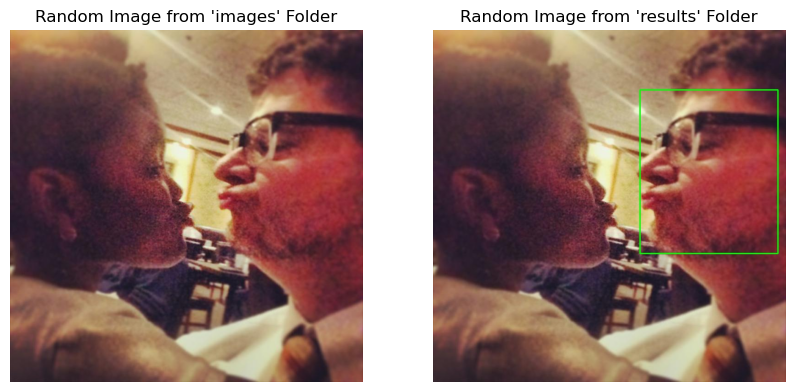

In [30]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# Paths
current_path = r'C:\Users\HP\Desktop\FaceRec\merged'
image_dir = "images"
result_dir = "results"
image_path = os.path.join(current_path, image_dir)
result_path = os.path.join(current_path, result_dir)

# Get the list of image names in both folders
image_names = set(os.listdir(image_path))
result_names = set(os.listdir(result_path))

# Find the common image names
common_image_names = list(image_names.intersection(result_names))

# Randomly select one common image name
random_common_image_name = np.random.choice(common_image_names)

# Load randomly selected images from both folders
random_image = cv2.imread(os.path.join(image_path, random_common_image_name))
random_result = cv2.imread(os.path.join(result_path, random_common_image_name))

# Display images using matplotlib
plt.figure(figsize=(10, 5))

# Plot the random image from the 'images' folder
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(random_image, cv2.COLOR_BGR2RGB))
plt.title("Random Image from 'images' Folder")
plt.axis('off')

# Plot the random image from the 'results' folder
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(random_result, cv2.COLOR_BGR2RGB))
plt.title("Random Image from 'results' Folder")
plt.axis('off')

plt.show()


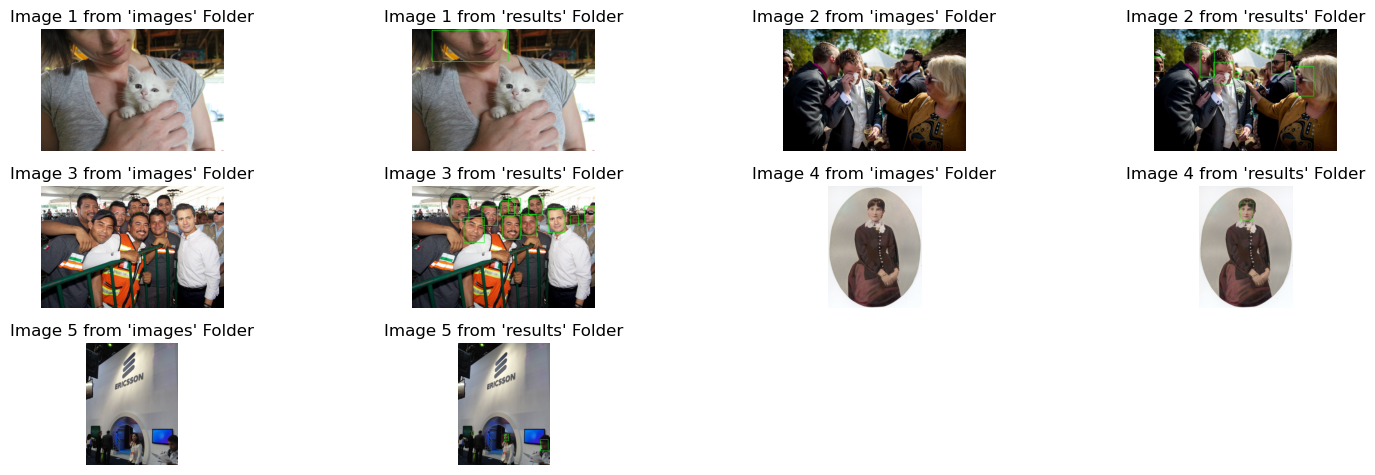

In [31]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# Paths
current_path = r'C:\Users\HP\Desktop\FaceRec\merged'
image_dir = "images"
result_dir = "results"
image_path = os.path.join(current_path, image_dir)
result_path = os.path.join(current_path, result_dir)

# Get the list of image names in both folders
image_names = set(os.listdir(image_path))
result_names = set(os.listdir(result_path))

# Find the common image names
common_image_names = list(image_names.intersection(result_names))

# Randomly select 10 common image names
random_common_image_names = np.random.choice(common_image_names, size=5, replace=False)

# Load and display the randomly selected common images from both folders
plt.figure(figsize=(15, 8))
for i, random_common_image_name in enumerate(random_common_image_names, 1):
    random_image = cv2.imread(os.path.join(image_path, random_common_image_name))
    random_result = cv2.imread(os.path.join(result_path, random_common_image_name))

    # Plot the random image from the 'images' folder
    plt.subplot(5, 4, 2*i - 1)
    plt.imshow(cv2.cvtColor(random_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Image {i} from 'images' Folder")
    plt.axis('off')

    # Plot the random image from the 'results' folder
    plt.subplot(5, 4, 2*i)
    plt.imshow(cv2.cvtColor(random_result, cv2.COLOR_BGR2RGB))
    plt.title(f"Image {i} from 'results' Folder")
    plt.axis('off')

plt.tight_layout()
plt.show()


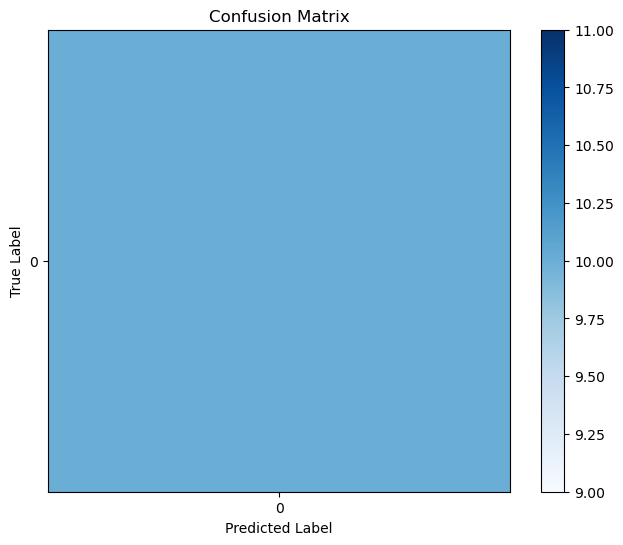

In [23]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Paths
current_path = r'C:\Users\HP\Desktop\FaceRec\merged'
image_dir = "images"
result_dir = "results"
image_path = os.path.join(current_path, image_dir)
result_path = os.path.join(current_path, result_dir)

# Get the list of image names in both folders
image_names = set(os.listdir(image_path))
result_names = set(os.listdir(result_path))

# Find the common image names
common_image_names = list(image_names.intersection(result_names))

# Randomly select 10 common image names
random_common_image_names = np.random.choice(common_image_names, size=10, replace=False)

# Ground truth and predicted labels
true_labels = []
predicted_labels = []

# Load and process the randomly selected common images
for random_common_image_name in random_common_image_names:
    # Load images
    random_image = cv2.imread(os.path.join(image_path, random_common_image_name))
    random_result = cv2.imread(os.path.join(result_path, random_common_image_name))

    # Assuming you have a method to extract ground truth labels
    # ground_truth_label = extract_label_from_image_name(random_common_image_name)
    # true_labels.append(ground_truth_label)

    # Assuming class ID 0 represents faces (for demonstration)
    true_labels.append(0)

    # Assuming you have a method to predict labels from the result images
    # predicted_label = predict_label(random_result)
    # predicted_labels.append(predicted_label)

    # Assuming the predicted label is also 0 (for demonstration)
    predicted_labels.append(0)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Display confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(np.arange(len(conf_matrix)))
plt.yticks(np.arange(len(conf_matrix)))
plt.show()


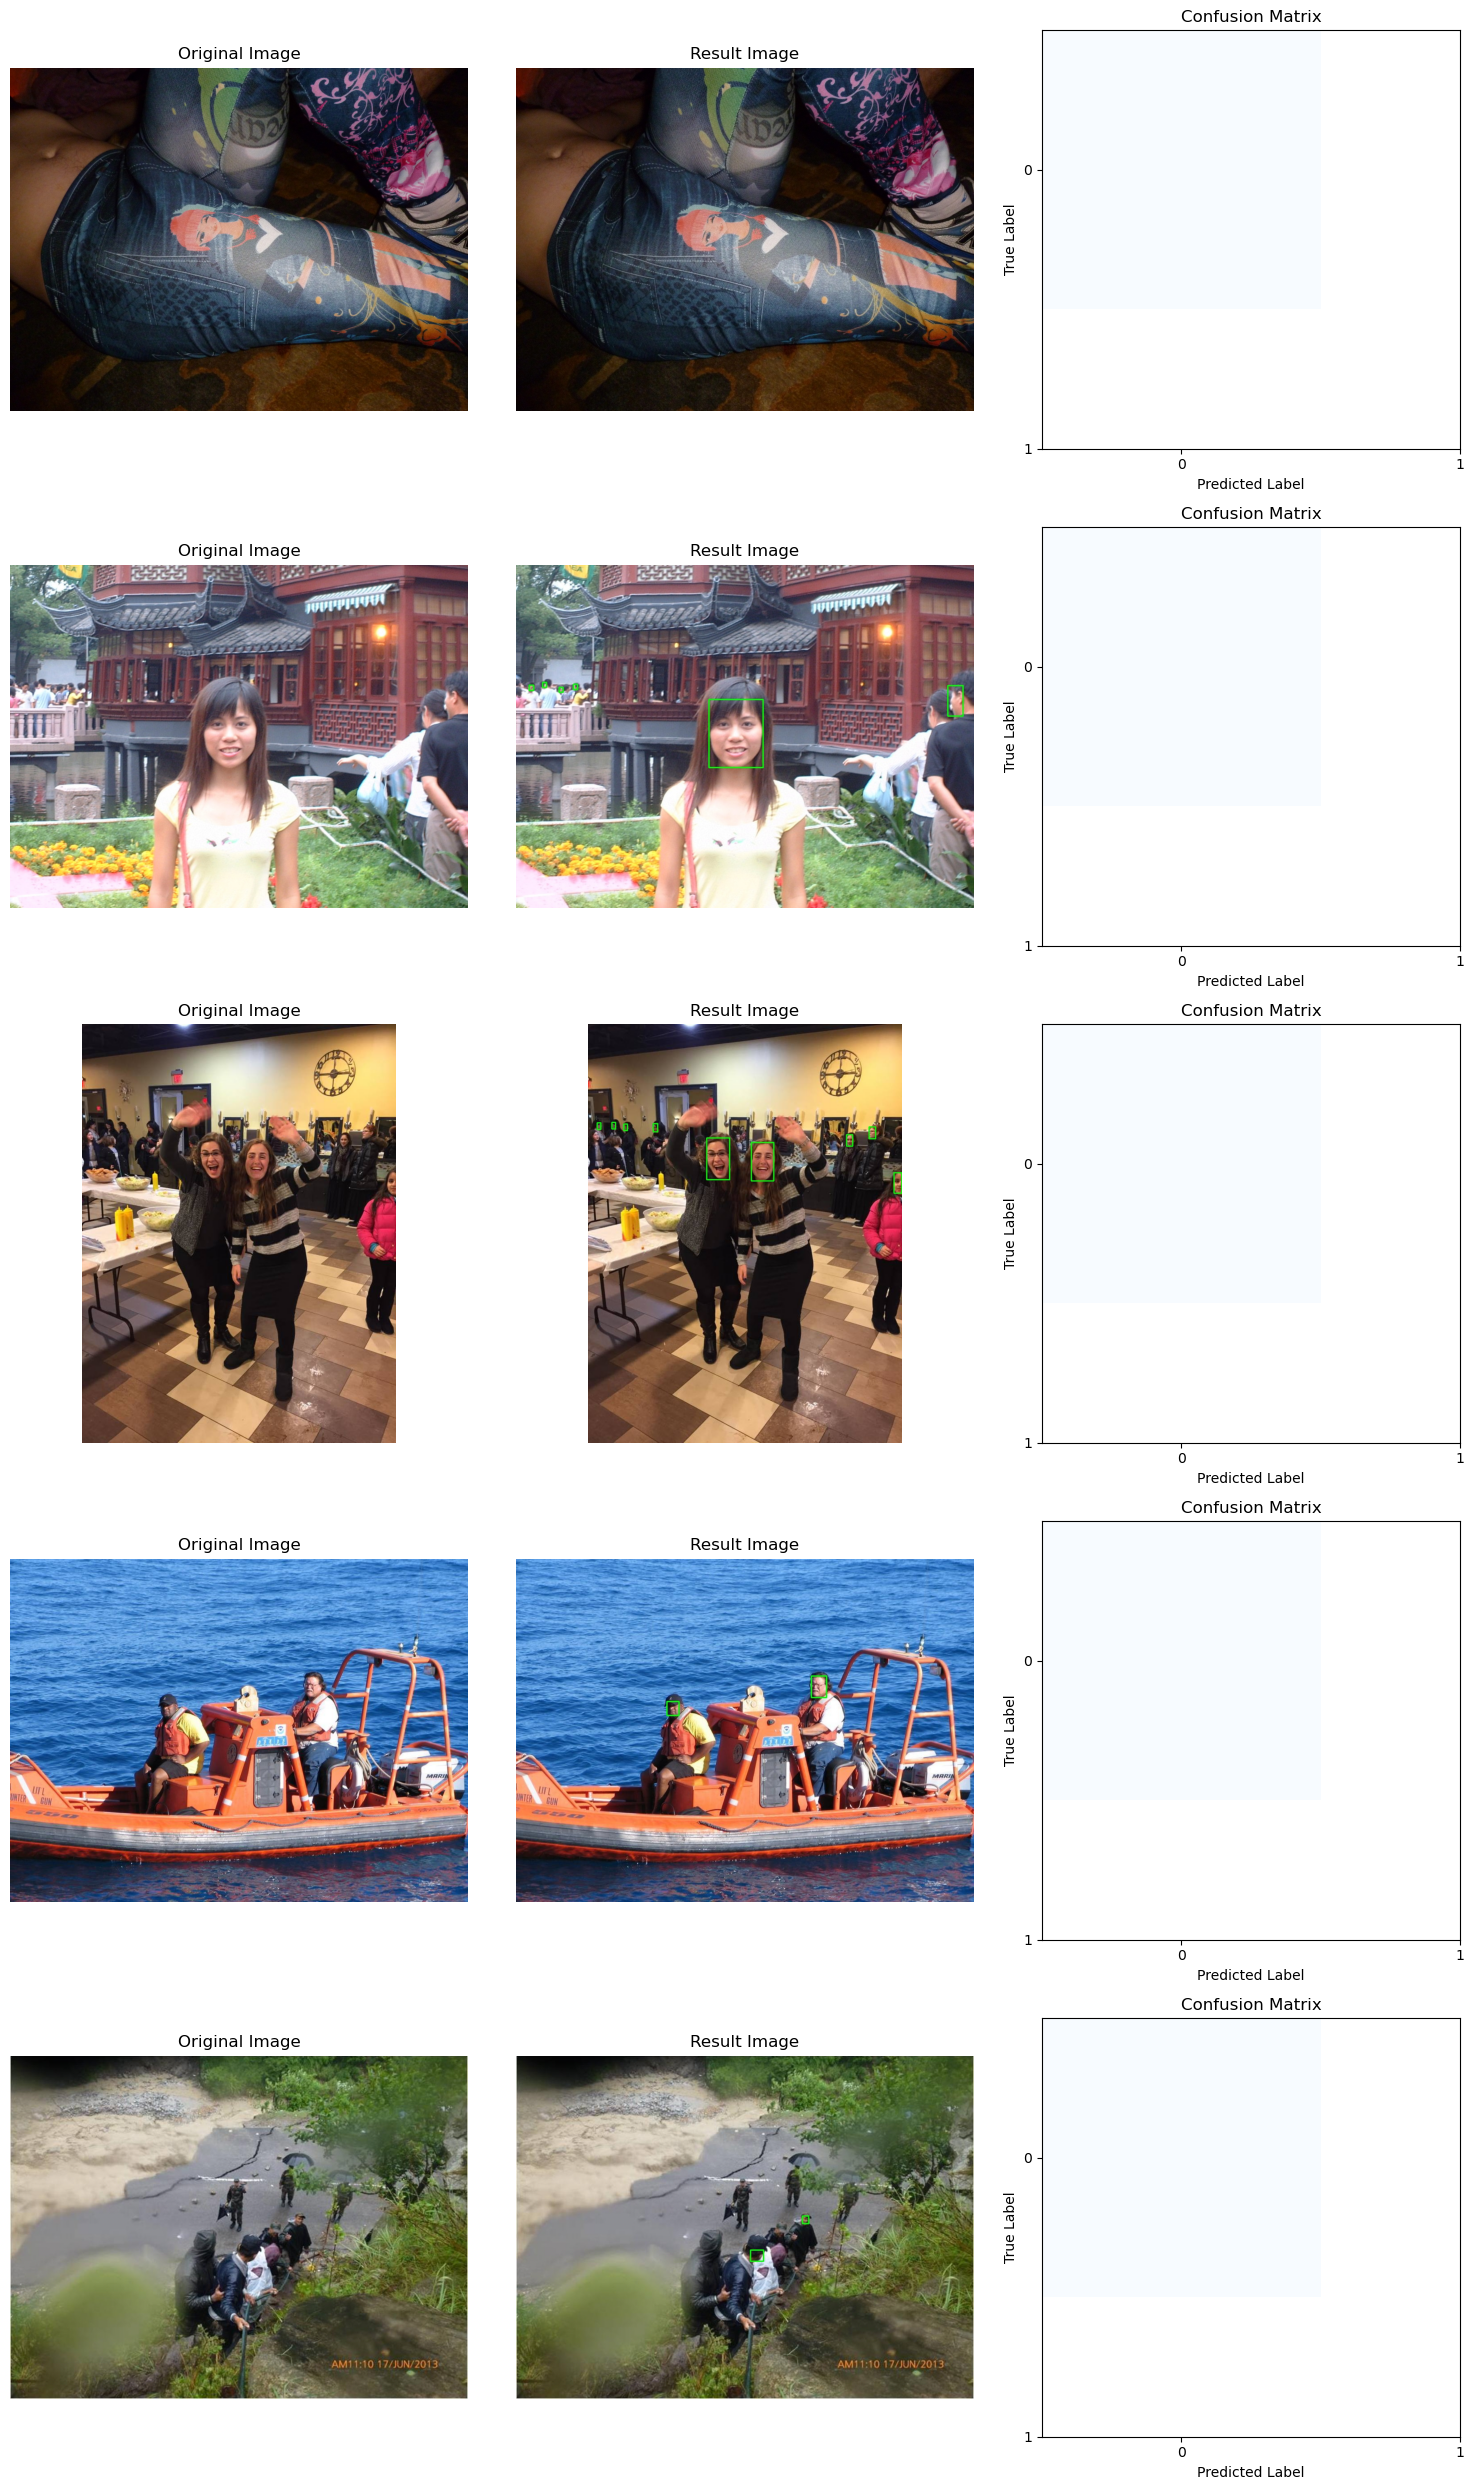

In [33]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Paths
current_path = r'C:\Users\HP\Desktop\FaceRec\merged'
image_dir = "images"
result_dir = "results"
image_path = os.path.join(current_path, image_dir)
result_path = os.path.join(current_path, result_dir)

# Get the list of image names in both folders
image_names = set(os.listdir(image_path))
result_names = set(os.listdir(result_path))

# Find the common image names
common_image_names = list(image_names.intersection(result_names))

# Randomly select 10 common image names
random_common_image_names = np.random.choice(common_image_names, size=5, replace=False)

# Set up subplots
fig, axs = plt.subplots(len(random_common_image_names), 3, figsize=(15, 5*len(random_common_image_names)))

# Iterate over each randomly selected common image
for i, random_common_image_name in enumerate(random_common_image_names):
    # Load the images
    random_image = cv2.imread(os.path.join(image_path, random_common_image_name))
    random_result = cv2.imread(os.path.join(result_path, random_common_image_name))

    # Assuming you have ground truth labels and predicted labels for each image
    # Extract or predict labels accordingly
    true_label = 0  # Placeholder for demonstration, replace with actual ground truth label
    predicted_label = 0  # Placeholder for demonstration, replace with actual predicted label

    # Compute confusion matrix for the current image
    conf_matrix = confusion_matrix([true_label], [predicted_label])

    # Display the image and its result
    axs[i, 0].imshow(cv2.cvtColor(random_image, cv2.COLOR_BGR2RGB))
    axs[i, 0].set_title('Original Image')
    axs[i, 0].axis('off')

    axs[i, 1].imshow(cv2.cvtColor(random_result, cv2.COLOR_BGR2RGB))
    axs[i, 1].set_title('Result Image')
    axs[i, 1].axis('off')

    # Display the confusion matrix
    axs[i, 2].imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    axs[i, 2].set_title('Confusion Matrix')
    axs[i, 2].set_xticks([0, 1])
    axs[i, 2].set_yticks([0, 1])
    axs[i, 2].set_xlabel('Predicted Label')
    axs[i, 2].set_ylabel('True Label')

# Adjust layout
plt.tight_layout()
plt.show()
